ref: https://arxiv.org/pdf/1402.1869v2.pdf

Since Toronto Face Dataset is not available for download, use Labeled Faces in the Wild dataset instead.

In [1]:
from __future__ import division
import time

# Import data
import tensorflow as tf

In [2]:
sess = tf.InteractiveSession()

In [32]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import random

In [4]:
plt.rc('image', cmap='gray')

In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [6]:
for name in lfw_people.target_names:
    print name

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Tony Blair


Keep the number of class the same as the paper so we can use the same NN architecture.

In [7]:
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data / 255.0
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [8]:
def plot_image(gray_scale):
    image = np.reshape(gray_scale, (lfw_people.images.shape[1], lfw_people.images.shape[2]))
    plt.imshow(image)
    plt.axis('off')

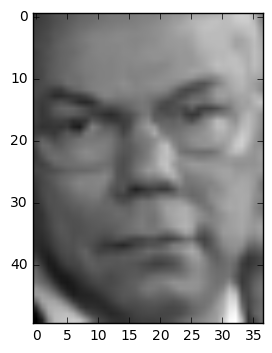

In [119]:
plt.imshow(lfw_people.images[5])

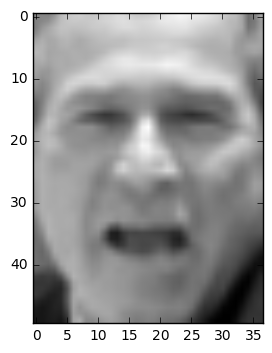

In [9]:
plt.imshow(lfw_people.images[10])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

In [11]:
class FacialNeuralNet:
    # According to paper, 3 layers hidden unit: (1000, 1000, 100) architecture.
    def __init__(self, epoch=1000, learning_rate=0.1, batch_size=100, lambda_=10**-3, model_path='checkpoint/eefr/fnn'):
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.lambda_ = lambda_
        self.model_path = model_path
        self.W1 = None
        self.W2 = None
        self.W3 = None
        self.W4 = None
        self.b1 = None
        self.b2 = None
        self.b3 = None
        self.b4 = None
    
    def fit(self, X, y, restore_step=0, checkpoint=False):
        y = self._reshape_y(y)
        d = X.shape[1]
        c = y.shape[1]

        tf_X = tf.placeholder(tf.float32, [None, d])
        tf_y = tf.placeholder(tf.float32, [None, c])
        self.W1 = tf.Variable(tf.random_normal([d, 1000], seed=1)/d)
        self.b1 = tf.Variable(tf.zeros(1000))
        self.W2 = tf.Variable(tf.random_normal([1000, 1000], seed=1)/1000)
        self.b2 = tf.Variable(tf.zeros(1000))
        self.W3 = tf.Variable(tf.random_normal([1000, 100], seed=1)/1000)
        self.b3 = tf.Variable(tf.zeros(100))
        self.W4 = tf.Variable(tf.random_normal([100, c], seed=1)/100)
        self.b4 = tf.Variable(tf.zeros(c))
        self.saver = tf.train.Saver({
            'W1': self.W1, 'b1': self.b1,
            'W2': self.W2, 'b2': self.b2,
            'W3': self.W3, 'b3': self.b3,
            'W4': self.W4, 'b4': self.b4
        })

        tf_keep_prob = tf.placeholder(tf.float32)
        z1 = tf.matmul(tf_X, self.W1) + self.b1
        a1 = tf.nn.relu(z1)
        z2 = tf.matmul(tf.nn.dropout(a1, tf_keep_prob), self.W2) + self.b2
        a2 = tf.nn.relu(z2)
        z3 = tf.matmul(tf.nn.dropout(a2, tf_keep_prob), self.W3) + self.b3
        a3 = tf.nn.relu(z3)
        z4 = tf.matmul(a3, self.W4) + self.b4

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z4, tf_y))

        loss = cross_entropy + self.lambda_ * (\
            tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(self.W3) + tf.nn.l2_loss(self.W4) +\
            tf.nn.l2_loss(self.b1) + tf.nn.l2_loss(self.b2) + tf.nn.l2_loss(self.b3) + tf.nn.l2_loss(self.b4))

        train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(loss)

        if restore_step > 0:
            self._restore(restore_step)
        else:
            sess.run(tf.initialize_variables([self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]))

        batch_start = 0
        for i in range(restore_step, self.epoch):
            batch_X, new_batch_start = self.next_batch(X, batch_start, self.batch_size)
            batch_y, _ = self.next_batch(y, batch_start, self.batch_size)
            batch_start = new_batch_start

            start_time = time.time()
            sess.run(train_step, feed_dict={tf_X: batch_X, tf_y: batch_y, tf_keep_prob: 0.5})
            if ((i+1) % ((self.epoch - restore_step) / 10) == 0):
                print "Epoch %d: %fs. Loss: %f" % (i+1, time.time()-start_time, sess.run(loss, feed_dict={
                    tf_X: batch_X, tf_y: batch_y, tf_keep_prob: 0.5
                }))
                if checkpoint:
                    self.save(i+1)

    def predict(self, X):
        tf_X = tf.placeholder(tf.float32, [None, X.shape[1]])
        z1 = tf.matmul(tf_X, self.W1) + self.b1
        a1 = tf.nn.relu(z1)
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = tf.nn.relu(z2)
        z3 = tf.matmul(a2, self.W3) + self.b3
        a3 = tf.nn.relu(z3)
        z4 = tf.matmul(a3, self.W4) + self.b4
        y_hat = tf.nn.softmax(z4)

        return sess.run(y_hat, feed_dict={tf_X: X})

    def save(self, global_step):
        self.saver.save(sess, self.model_path, global_step)

    def _restore(self, global_step):
        self.saver.restore(sess, self.model_path + '-' + str(global_step))

    def _reshape_y(self, y):
        new_y = np.zeros((y.shape[0], np.max(y)+1))
        new_y[range(len(y)), y] = 1
        return new_y

    def next_batch(self, elements, index, n):
        size = len(elements)
        if index >= size or index < 0:
            return None, -1
        elif n >= size:
            return elements, 0
        elif index + n > size:
            return np.append(elements[index:], elements[:(n-(size-index))], axis=0), n-(size-index)
        else:
            return elements[index:index+n], 0 if (index+n) == size else index+n

In [12]:
nn = FacialNeuralNet(epoch=100000, batch_size=100, learning_rate=0.1)
start_time = time.time()
nn.fit(X_train, y_train, restore_step=100000, checkpoint=True)
print 'Total time:', time.time() - start_time

Total time: 0.458463907242


In [13]:
y_hat = nn.predict(X_test)
accuracy_score(y_test, np.argmax(y_hat, 1))

0.54037267080745344

Unfortunately, since it is a different dataset compared to the one in paper, the NN does not perform well in the LFW dataset using the same architecture for TFD.

In [14]:
W1 = sess.run(nn.W1)

In [15]:
def plot_first_layer_grid(w):
    sample_unit_size = 900
    plt.figure(figsize =(8,8))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, unit_i in enumerate(xrange(sample_unit_size)):
        p = plt.subplot(30, 30, i+1)
        plot_image(w[:,unit_i])

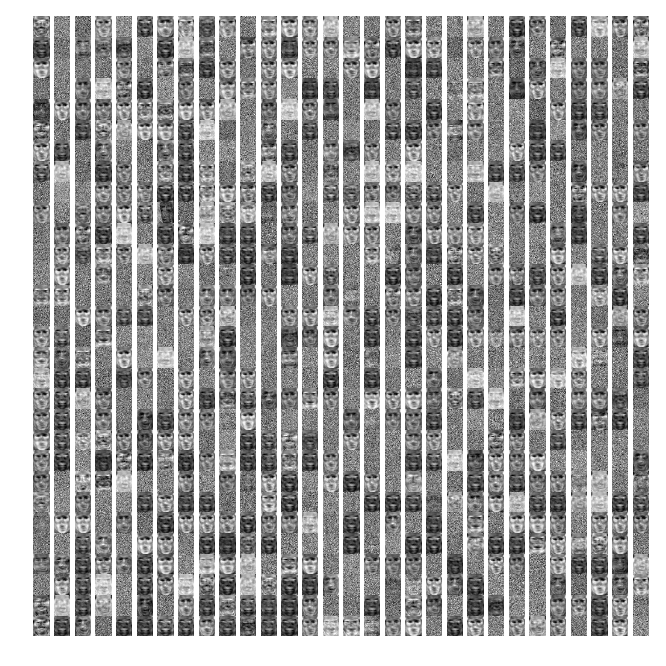

In [197]:
plot_first_layer_grid(W1)

## Plot Linear Map to Evaluate Folding

In [82]:
def plot_first_layer_16(w):
    sample_unit_size = 16
    plt.figure(figsize =(3,4))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, unit_i in enumerate(random.sample(range(w.shape[1]), 16)):
        p = plt.subplot(4, 4, i+1)
        plot_image(w[:,unit_i])

In [99]:
def linear_responses(X, nn, l=2):
    ''' Formula 8 in the paper.
    
    Calculate the linear map of each example for a sample of 20 units in a network for the specified layer.
    For each unit, only the linear maps of active examples are considered.
    '''
    if l < 2 or l > 4:
        return

    weights = [sess.run(nn.W1), sess.run(nn.W2), sess.run(nn.W3), sess.run(nn.W4)]
    biases = [sess.run(nn.b1), sess.run(nn.b2), sess.run(nn.b3), sess.run(nn.b4)]

    z1 = X.dot(weights[0]) + biases[0]
    a1 = sess.run(tf.nn.relu(z1))
    z2 = a1.dot(weights[1]) + biases[1]
    a2 = sess.run(tf.nn.relu(z2))
    z3 = a2.dot(weights[2]) + biases[2]
    a3 = sess.run(tf.nn.relu(z3))
    z4 = a3.dot(weights[3]) + biases[3]
    a4 = sess.run(tf.nn.softmax(z4))

    zs = [z1, z2, z3, z4]
    activations = [a1, a2, a3, a4]

    d = X.shape[1]
    l_shape = weights[(l-1)].shape[1]
    sample_hidden_unit = random.sample(range(l_shape), 20) if l_shape >= 20 else range(l_shape)
    responses = {unit: [] for unit in sample_hidden_unit}

    for i in xrange(X.shape[0]):
        u_matrixes = []
        for j in xrange(l):
            u_matrixes.append(weights[j])
            if j < (l-1):
                u_matrixes.append(np.diag((activations[j][i] > 0).astype(int)))

        u = np.identity(d)
        for m in u_matrixes:
            u = u.dot(m)

        if l != 4:
            for unit in responses.keys():
                if activations[(l-1)][i][unit] > 0:
                    responses[unit].append(u[:,unit])
        else:
            output_unit = np.argmax(activations[(l-1)][i])
            responses[output_unit].append(u[:,output_unit])

    return responses

In [120]:
def euclidean_distance(centroids):
    ''' Calculate the average pairwise euclidean distance between centroids
    '''
    distances = []
    for i in xrange((len(centroids) - 1)):
        for j in xrange(i+1, len(centroids)):
            distances.append(np.linalg.norm(centroids[i]-centroids[j]))
    return np.mean(distances)

def top_representative_linear_responses(responses, limit=4):
    ''' Find the 4 most representative linear maps within each unit and return the top units who have the maximal 
    euclidean distance.
    
    :param responses: Linear responses for units.
    :param limit: The maximum number of unit to return.
    '''
    representitive_responses = {}
    for unit, resps in responses.iteritems():
        if len(resps) > 4:
            km = KMeans(n_clusters=4)
            km.fit(resps)
            representitive_responses[unit] = km.cluster_centers_
    top = sorted(representitive_responses.items(), key=lambda (unit, resps): euclidean_distance(resps), reverse=True)[:limit]
    return top

In [93]:
def plot_linear_responses_16(responses):
    plt.figure(figsize =(3,4))
    plt.subplots_adjust(wspace=0, hspace=0)
    i = 1
    for (_, resps) in responses:
        for r in resps:
            p = plt.subplot(4, 4, i)
            plot_image(r)
            i += 1

In [ ]:
responses_l2 = linear_responses(X_train, nn, l=2)

In [ ]:
top_4_responses_l2 = top_representative_linear_responses(responses_l2, limit=4)

In [95]:
responses_l3 = linear_responses(X_train, nn, l=3)

In [96]:
top_4_responses_l3 = top_representative_linear_responses(responses_l3, limit=4)

In [100]:
responses_output = linear_responses(X_train, nn, l=4)

In [106]:
top_responses_output = top_representative_linear_responses(responses_output, limit=7)

L1 linear map:


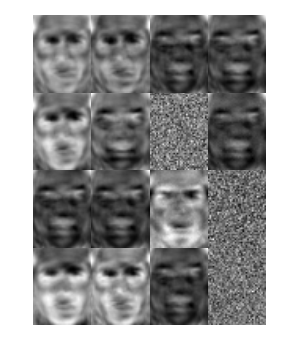

L2 linear map:


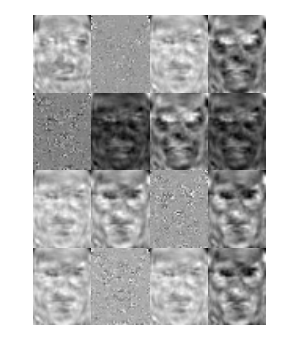

L3 linear map:


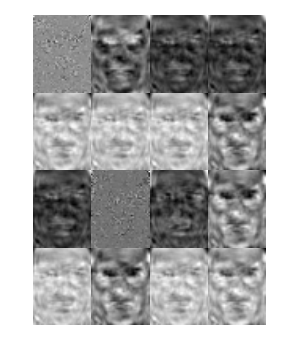

Output linear map:


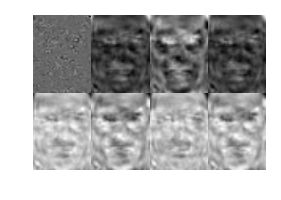

In [109]:
print "L1 linear map:"
plot_first_layer_16(W1)
plt.show()
print "L2 linear map:"
plot_linear_responses_16(top_4_responses_h2)
plt.show()
print "L3 linear map:"
plot_linear_responses_16(top_4_responses_h3)
plt.show()
print "Output linear map:"
plot_linear_responses_16(top_responses_output)
plt.show()

## Observation

The linear maps from higher layer respond to more abstract features. For example, higher layers are invariant to face shape, eyebrow, etc. In the output layer, it successfully captures the color difference between the 2 classes that the neural network can identify (Colin Powell and Georage Bush).